# Libraries, data...

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from statsmodels.multivariate.pca import PCA as PCA
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import calinski_harabasz_score as score_ch
from sklearn.metrics import davies_bouldin_score as score_db
from sklearn.metrics import silhouette_score as score_sc
from GapStat import gap_stat
from statsmodels.tsa.stattools import adfuller

Import data

In [32]:
for i in range(10):
    if i==0:
        ALL_STOCKS=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', i+2, usecols=[0,20])
        NAMES=list(ALL_STOCKS)
        ALL_STOCKS=np.array(ALL_STOCKS)
        SECTOR_ID=np.zeros((ALL_STOCKS.shape[1]))
    else:
        load=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', i+2, usecols=[1,20])
        NAMES=NAMES+list(load)
        ALL_STOCKS=np.append(ALL_STOCKS,np.array(load),axis=1)
        SECTOR_ID=np.append(SECTOR_ID,np.zeros((np.array(load).shape[1]))+i)
SP500=np.array(pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', 'MarketIndex', usecols='B'))
SECTOR_LABELS=['Communication services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Healthcare', 'Industrials','Information Technology', 'Materials', 'Utilities' ]

In [49]:
stocks = ALL_STOCKS[0:,1:].astype(np.float64)
tt =ALL_STOCKS.index

AttributeError: 'numpy.ndarray' object has no attribute 'index'

Missing data

In [51]:
#select=(1-np.sum(np.isnan(stocks),axis=0)==1)
STOCKS_SELECT=ALL_STOCKS[0:,1:]
#select_id=np.arange(0,ALL_STOCKS.shape[1],1)[select]
#NAMES_SELECT=[NAMES[i] for i in select_id]
#SECTOR_ID_SELECT=SECTOR_ID[select]
n_stocks=STOCKS_SELECT.shape[1]

Return computation

In [52]:
RETURNS=STOCKS_SELECT[1:,:]/STOCKS_SELECT[:-1,:]-1
RETURNS_NORM=preprocessing.scale(RETURNS)
RETURNS_SP500=SP500[1:,:]/SP500[:-1,:]-1
n_obs=len(RETURNS)

In [53]:
n_stocks=STOCKS_SELECT.shape[1]
n_obs=len(STOCKS_SELECT)

## 2.1. Principal component analysis

19 factors retreiving 100 percent of the global variance


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (20,) and arg 1 with shape (19,).

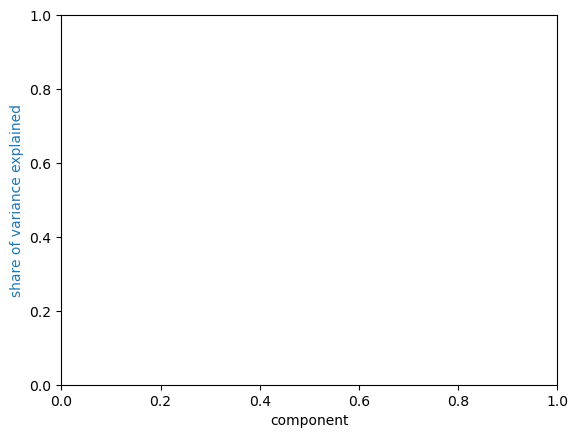

In [54]:
out_pca=PCA(RETURNS_NORM)

share_variance=out_pca.eigenvals[:20]/sum(out_pca.eigenvals)
share_variance_cumulated=np.cumsum(share_variance)

N_FACTORS=min((out_pca.ic[:20,:]).argmin(axis=0))+1
print('%i factors retreiving ' %(N_FACTORS)+ '%i percent of the global variance' %(share_variance_cumulated[N_FACTORS-1]*100))

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('component')
ax1.set_ylabel('share of variance explained', color=color)
ax1.bar(np.arange(1,21,1), share_variance, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cumulated share of variance explained', color=color)
ax2.plot(np.arange(1,21,1), share_variance_cumulated, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

In [7]:
N_FACTORS=min((out_pca.ic[:50,:]).argmin(axis=0))+1
FACTORS=preprocessing.scale((out_pca.factors)[:,0:N_FACTORS])
FEATURES=np.zeros((n_stocks,N_FACTORS))
for i in range(n_stocks):
    model=sm.OLS(RETURNS[:,i],sm.add_constant(FACTORS))
    out_model=model.fit()
    FEATURES[i,:]=out_model.params[1:]
FEATURES=preprocessing.scale(FEATURES)

In [11]:
FEATURES.shape

(453, 5)

## 2.2. Clustering from normalized stock features

### 2.2.1. Computing Euclidean distance from stock features

In [8]:
DIST_1=pdist(FEATURES,'euclidean')
clustering = linkage(DIST_1,method='ward')

### 2.2.2. GAP Stat

[]

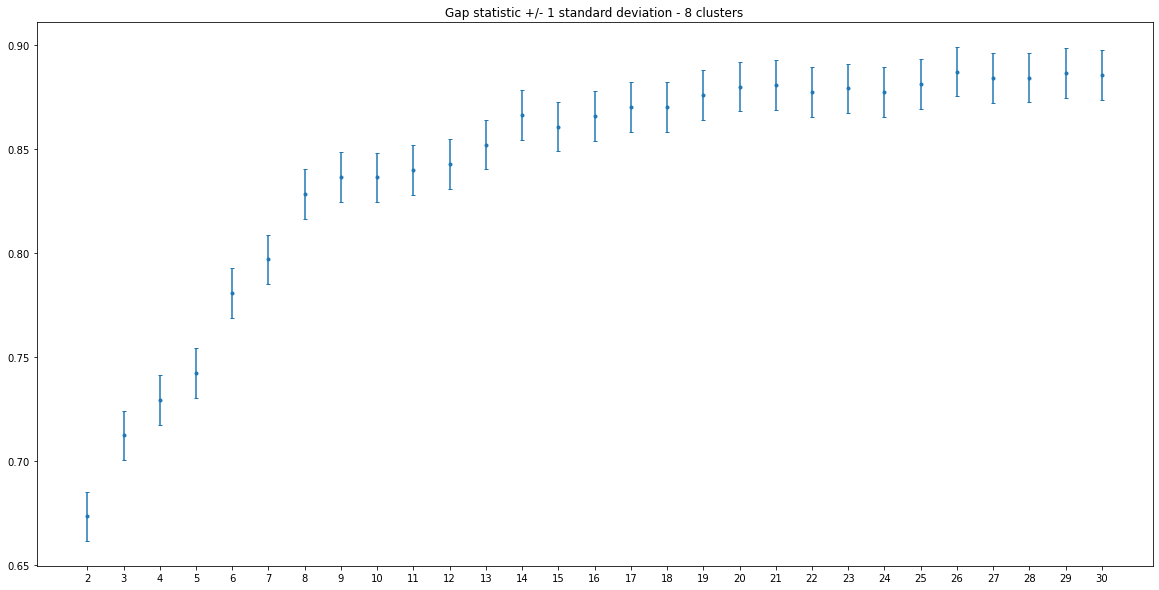

In [18]:
cmax=30
N_CLUSTER=0
GAP_OUT=np.zeros((cmax-1,2))
for i in np.arange(2,cmax+1,1):
    clusters=fcluster(clustering,i,criterion='maxclust')
    out=gap_stat('euclidean', 'ward', FEATURES.T, DIST_1, clusters, 20)
    GAP_OUT[i-2,:]=[out[0],out[1]]
std_GAP=np.mean(out[1])
for i in np.arange(2,cmax,1):
    if GAP_OUT[i-2,0]>(GAP_OUT[i-1,0]-GAP_OUT[i-1,1]):
        N_CLUSTER=i
        break

plt.figure(figsize=(20, 10))
plt.errorbar(np.arange(2,cmax+1,1), GAP_OUT[:,0], GAP_OUT[i-1,1], capsize=2, fmt='.')
plt.title("Gap statistic +/- 1 standard deviation - %i clusters" %N_CLUSTER)
plt.xticks(np.arange(2,cmax+1,1))
plt.plot()

### 2.2.3. Dendrogram

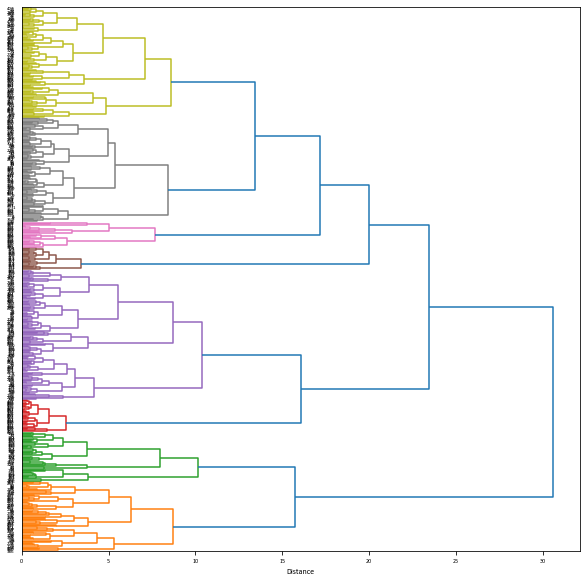

In [19]:
plt.figure(figsize=(10, 10))
csfont = {'fontname':'Calibri', 'fontsize' : '10'}
csfont2 = {'fontname':'Calibri', 'fontsize' : '8'}
csfont3 = {'fontname':'Calibri', 'fontsize' : '6'}
plt.xlabel('Distance',**csfont2)
plt.xticks(**csfont3)
plt.yticks(**csfont3)
dendrogram(clustering,truncate_mode='level',orientation='right',leaf_font_size=5,color_threshold=11)
plt.savefig('books_read.jpeg',bbox_inches='tight', dpi=300)
plt.show()

# 3. Hierarchical Equal CVaR allocation

## 3.1. CVaR computation

In [20]:
CVaR=np.zeros((n_stocks))
WEIGHTS=np.zeros((n_stocks))

for i in range(len(CVaR)):
    Q05=np.quantile(RETURNS[:,i],0.05)
    CVaR[i]=abs(np.mean(RETURNS[RETURNS[:,i]<Q05,i]))

## 3.2. Within cluster allocation

In [21]:
clusters=fcluster(clustering,8,criterion='maxclust')



WEIGHTS_WITHIN=np.zeros((max(clusters),n_stocks))
RETURNS_CLUSTERS=np.zeros((len(RETURNS),max(clusters)))
CVaR_CLUSTERS=np.zeros((max(clusters)))
WEIGHTS_BETWEEN=np.zeros((max(clusters)))
WEIGHTS=np.zeros((n_stocks))

for c in range(max(clusters)):
    WEIGHTS_WITHIN[c,clusters==c+1]=(1/CVaR[clusters==c+1])/np.sum(1/CVaR[clusters==c+1])
    RETURNS_CLUSTERS[:,c]=np.sum(WEIGHTS_WITHIN[c,:]*RETURNS,axis=1)
    Q05=np.quantile(RETURNS_CLUSTERS[:,c],0.05)
    CVaR_CLUSTERS[c]=abs(np.mean(RETURNS_CLUSTERS[RETURNS_CLUSTERS[:,c]<Q05,c]))
WEIGHTS_BETWEEN=(1/CVaR_CLUSTERS)/np.sum(1/CVaR_CLUSTERS)
for c in range(max(clusters)):
    WEIGHTS[clusters==c+1]=WEIGHTS_WITHIN[c,clusters==c+1]*WEIGHTS_BETWEEN[c]